In [1]:
!pwd

/home/kslab/jupyter/Eddie/aws


## 資料集

In [2]:
import os
from PIL import Image
from datasets import Dataset, Features, ClassLabel, Image as DatasetImage, Value

def batch_process_images(folder_path):
    images = []
    image_file_paths = []
    labels_id = []
    # labels_real = []
    
    # 獲取資料夾中的所有檔案
    files = os.listdir(folder_path)

    for root, dirs, files in os.walk(folder_path):
        for file_name in files:
            # 略过 .ipynb_checkpoints 文件夹中的文件
            if '.ipynb_checkpoints' in root:
                continue
            
            # 检查文件是否为图像文件
            if file_name.endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):
                try:
                    # 假设文件名格式为 label_filename.jpg
                    # label = file_name[3:-4]  # 从文件名中提取标签
                    label_id = int(file_name.split('_')[0])
                    # label = int(file_name.split('_')[0])  # 从文件名中提取标签
                    image_file_path = os.path.join(root, file_name)  # 图像的完整文件路径
                    image = Image.open(image_file_path)  # 读取图像
                    # 試試看
                    if image.mode == 'RGBA':
                        image = image.convert("RGB")

                    # 将图像、文件路径和标签添加到相应的列表中
                    images.append(image)
                    image_file_paths.append(image_file_path)
                    labels_id.append(label_id)
                    # labels_real.append(label)
                    
                except ValueError as e:
                    print(f"Skipping file {file_name} due to error: {e}")
    # 構建所需的資料結構
    dataset = {
        'image': images,
        'image_file_path': image_file_paths,
        'labels': labels_id
    }

    return dataset

# 呼叫函數處理資料夾中的圖片
folder_path = '/home/kslab/jupyter/Eddie/aws/images'
prepared_dataset_dict = batch_process_images(folder_path)

# features = Features({
#     'image': DatasetImage(),
#     'image_file_path': Value('string'),
#     'labels': ClassLabel(names=labels_real)  # Modify this according to your labels
# })

# dataset = Dataset.from_dict(prepared_dataset_dict, features=features)

# 打印轉換後的資料結構
print(prepared_dataset_dict)


{'image': [<PIL.Image.Image image mode=RGB size=148x132 at 0x7FC9FFA84710>, <PIL.Image.Image image mode=RGB size=148x132 at 0x7FC9FEDD8390>, <PIL.Image.Image image mode=RGB size=146x126 at 0x7FCA76496210>, <PIL.Image.Image image mode=RGB size=155x140 at 0x7FC9FEC88E90>, <PIL.Image.Image image mode=RGB size=148x128 at 0x7FC9FF0D9590>, <PIL.Image.Image image mode=RGB size=152x131 at 0x7FC9FEC89510>, <PIL.Image.Image image mode=RGB size=165x143 at 0x7FC9FFAC9B50>, <PIL.Image.Image image mode=RGB size=163x138 at 0x7FC9FF0F9C90>, <PIL.Image.Image image mode=RGB size=157x132 at 0x7FC9FF0F9E50>, <PIL.Image.Image image mode=RGB size=154x129 at 0x7FC9FEC894D0>, <PIL.Image.Image image mode=RGB size=151x129 at 0x7FC9FEC8A510>], 'image_file_path': ['/home/kslab/jupyter/Eddie/aws/images/03_Green.png', '/home/kslab/jupyter/Eddie/aws/images/10_J.png', '/home/kslab/jupyter/Eddie/aws/images/08_K.png', '/home/kslab/jupyter/Eddie/aws/images/02_Gold.png', '/home/kslab/jupyter/Eddie/aws/images/04_Blue.png'

In [3]:
train = test = prepared_dataset_dict

In [4]:
img = train['image'][0]

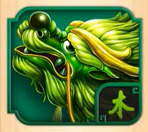

In [5]:
img

## 模型

In [6]:
from transformers import ViTImageProcessor

model_name_or_path = 'google/vit-base-patch16-224-in21k'
processor = ViTImageProcessor.from_pretrained(model_name_or_path)

In [7]:
# # 下載和讀取圖片
# url = 'http://images.cocodataset.org/val2017/000000039769.jpg'
# image = Image.open(requests.get(url, stream=True).raw)

# # 定義標籤和對應的數字 id
# labels = ['cat', 'dog', 'bird', 'horse', 'fish'] # 這裡放我們自己定義的類別，例如AKQJ、藍龍
# label2id = {label: idx for idx, label in enumerate(labels)}
# id2label = {idx: label for label, idx in label2id.items()}

# # 創建訓練用的數據
# # 這裡假設你有一個圖片數據集和對應的標籤列表
# # 你需要將圖片和標籤對應起來，並轉換為模型可接受的格式
# # 這裡我們簡單地將一張圖片複製 5 次，並使用不同的標籤
# images = [image] * 5
# labels = [label2id['cat']] * 5  # 假設這些圖片都是貓的圖片

In [8]:
def transform(example_batch):
    # Take a list of PIL images and turn them to pixel values
    inputs = processor([x for x in example_batch['image']], return_tensors='pt')

    # Don't forget to include the labels!
    inputs['labels'] = example_batch['labels']
    return inputs

In [9]:
# def transform(example):
#     inputs = processor(example['image'], return_tensors='pt')
#     inputs['labels'] = example['labels']
#     return inputs

In [10]:
from datasets import Dataset


# 將字典轉換為 Hugging Face datasets 資料結構
train_dataset = Dataset.from_dict(train)
test_dataset = Dataset.from_dict(test)

# 顯示資料集的前幾個樣本
print(train_dataset)


Dataset({
    features: ['image', 'image_file_path', 'labels'],
    num_rows: 11
})


In [11]:
trainingData = train_dataset.with_transform(transform)
testingData = test_dataset.with_transform(transform)

In [12]:
testingData[0:2]

{'pixel_values': tensor([[[[ 0.8902,  0.9059,  0.9294,  ...,  0.9529,  0.9451,  0.9451],
          [ 0.8902,  0.9059,  0.9294,  ...,  0.9529,  0.9451,  0.9451],
          [ 0.8980,  0.9137,  0.9373,  ...,  0.9608,  0.9529,  0.9451],
          ...,
          [ 0.8745,  0.8980,  0.9294,  ...,  0.9608,  0.9686,  0.9765],
          [ 0.8745,  0.8980,  0.9216,  ...,  0.9608,  0.9686,  0.9765],
          [ 0.8745,  0.8980,  0.9216,  ...,  0.9608,  0.9686,  0.9765]],

         [[ 0.5137,  0.5765,  0.6471,  ...,  0.6784,  0.6627,  0.6471],
          [ 0.5137,  0.5765,  0.6471,  ...,  0.6784,  0.6627,  0.6471],
          [ 0.5137,  0.5765,  0.6471,  ...,  0.6784,  0.6627,  0.6471],
          ...,
          [ 0.4902,  0.5608,  0.6314,  ...,  0.6784,  0.6784,  0.6784],
          [ 0.4902,  0.5608,  0.6392,  ...,  0.6863,  0.6784,  0.6784],
          [ 0.4902,  0.5608,  0.6392,  ...,  0.6863,  0.6784,  0.6784]],

         [[ 0.2078,  0.2314,  0.2549,  ...,  0.2706,  0.2392,  0.2157],
          [ 0

In [13]:
import torch

def collate_fn(batch):
    return {
        'pixel_values': torch.stack([x['pixel_values'] for x in batch]),
        'labels': torch.tensor([x['labels'] for x in batch])
    }


In [14]:
torch.tensor([x['labels'] for x in testingData])

tensor([ 3, 10,  8,  2,  4,  6,  1,  0,  7,  5,  9])

In [15]:
import numpy as np
from datasets import load_metric

metric = load_metric("accuracy")
def compute_metrics(p):
    return metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids)


/tmp/ipykernel_3229452/311509507.py:4: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("accuracy")
/home/kslab/anaconda3/envs/jupyter/lib/python3.11/site-packages/datasets/load.py:756: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.18.0/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


In [16]:
labels = train['labels']
labels

[3, 10, 8, 2, 4, 6, 1, 0, 7, 5, 9]

In [17]:
from transformers import ViTForImageClassification

model = ViTForImageClassification.from_pretrained(
    model_name_or_path,
    num_labels=len(set(labels)),
    id2label={str(i): c for i, c in enumerate(labels)},
    label2id={c: str(i) for i, c in enumerate(labels)}
)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [18]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir='./jumbo',
    per_device_train_batch_size=16,
    evaluation_strategy="steps",
    num_train_epochs=4,
    fp16=True,
    save_steps=10,
    eval_steps=10,
    logging_steps=10,
    learning_rate=2e-4,
    save_total_limit=2,
    remove_unused_columns=False,
    push_to_hub=False,
    report_to='tensorboard',
    load_best_model_at_end=True,
    logging_dir='./jumbo/logs',
    # load_best_model_at_end=True,
)


In [19]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    train_dataset=trainingData,
    eval_dataset=testingData,
    tokenizer=processor,
)


/home/kslab/anaconda3/envs/jupyter/lib/python3.11/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


In [20]:
train_results = trainer.train()

RuntimeError: GET was unable to find an engine to execute this computation